# Investigating the effect of patient features by varying feature values

In this notebook we start with a 'base patient' who has features that are favourable to use of thrombolysis:

* Onset to arrival = 80 mins
* Arrival to scan = 20 mins
* Infarction = 1 
* NIHSS = 15
* Prior disability level = 0
* Precise onset time = 1
* Use of AF anticoagulents = 0

We then vary the following features in turn, keeping all other features the same as the base patient:

* NIHSS = 0-40
* Prior disability level = 0-5
* Precise onset time = 0-1

Perceived reasons to *not* give thrombolysis appear more than additive - many hopsitals will accept one marginal reason not to give thrombolysis, but the combination of marginal reasons have a large effect than if these reasons were all considered independently.

The number of hospitals giving thrombolysis:

* Base patient: 132 (99%)
* Base patient, but NIHSS = 5: 120 (91%)
* Base patient, but pre-stroke disability = 2: 126 (96%)
* Base patient, but estimated stroke onset time: 84 (64%)
* Base patient, but NIHSS = 5, pre-stroke disability = 2, estimated stroke onset time: 3 (2.3%)


## Observations

* There are interactions between features in the number of hopsitals that would give patients thrombolysis.
* Changing three features individually (stroke severity NIHSS=5, pre-stroke disablity =2, estimated stroke onset) have minor effects alone, but when combined only 8 out of 132 hopsitals (6.2%) are predicted to give thrombolysis to that patient.

## Import libraries

In [4]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import shap

from scipy import stats

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier
import json

# So can load package from a parallel folder
#import sys
# caution: path[0] is reserved for script path (or '' in REPL)
#sys.path.insert(1, '../xgb_with_feature_selection')
#import utils

#import ../xgb_with_feature_selection/utils
import importlib
#from ..xgb_with_feature_selection/utils import waterfall

#from application.app.folder.file import func_name

#export PYTHONPATH=/path/to/parent  # linux/macOS

# Import from a relative path
import os, sys
# Get current working directory (absolute path)
cwd = os.getcwd()
# Define path to where package is (this goes up one directory)
path = cwd + '/../xgb_with_feature_selection/'
# Add path so Python will look here
sys.path.append(path)
# We can now import the helper module
from utils import waterfall
# Force package to be reloaded
importlib.reload(waterfall) 


<module 'utils.waterfall' from '/home/kerry/Documents/GitHub/samuel_shap_paper_1/key_notebooks_redundant/../xgb_with_feature_selection/utils/waterfall.py'>

## Set filenames

In [5]:
# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
model_type = 'xgb_8_features'
notebook = '20_synthetic'
number_of_features_to_use = 8

## Create output folders if needed

In [6]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file
Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [7]:
with open("../xgb_with_feature_selection/output/feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

10k cohort of patients in test data, rest in training data

In [8]:
data_loc = '../data/10k_training_test/'

In [9]:
# Load data
train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')
synthetic = pd.read_csv(data_loc + 'cohort_10000_key_features_synthetic.csv')

# Read in the names of the selected features for the model
key_features = pd.read_csv('../xgb_with_feature_selection/output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append("S2Thrombolysis")

# Extract just the key features
train = train[key_features]
test = test[key_features]

# Rename the columns
train.rename(columns=feature_name_dict, inplace=True)
test.rename(columns=feature_name_dict, inplace=True)

## Fit XGBoost model

Train a XGBoost model on the 10k cohort train/test dataset

In [10]:
# Get X and y
X_train = train.drop('Thrombolysis', axis=1)
X_test = test.drop('Thrombolysis', axis=1)
y_train = train['Thrombolysis']
y_test = test['Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('Stroke team', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('Stroke team', axis=1, inplace=True)    

# Define model
model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)

# Fit model
model.fit(X_train, y_train)

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test)[:,1]
y_pred = y_probs > 0.5\

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.841


## Get SHAP values (to use in waterfall plots later)

In [11]:
# Set up explainer using the model and feature values from training set
explainer = shap.TreeExplainer(model, X_train)

## Predict thrombolysis with varying patient features

The base patient has the following values:

* Onset to arrival = 80 mins
* Arrival to scan = 20
* Infaction = 1 
* NIHSS = 15
* Prior disability level = 0
* Precise onset time = 1
* Use of AF anticoagulents = 0

We then vary the following features in turn, keeping all other features the same as the base patient:

* NIHSS = 0-40
* Prior disability level = 0-5
* Precise onset time = 0-1

In [12]:
hospitals = synthetic['Stroke team']
X_synthetic = synthetic.drop('Thrombolysis', axis=1)
y_synthetic = synthetic['Thrombolysis']
X_synthetic_hosp = pd.get_dummies(X_synthetic['Stroke team'], prefix = 'team')
X_synthetic = pd.concat([X_synthetic, X_synthetic_hosp], axis=1)
X_synthetic.drop('Stroke team', axis=1, inplace=True)

In [13]:
# Adjust NIHSS
number_thrombolysing_NIHSS = []
for stroke_sev in range(41):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Stroke severity'] = stroke_sev
    y_probs = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_probs > 0.5
    number_thrombolysing_NIHSS.append(y_pred.sum())

# Adjust Prior disability
number_thrombolysing_mrs = []
for mrs in range(6):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Prior disability level'] = mrs
    y_probs = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_probs > 0.5
    number_thrombolysing_mrs.append(y_pred.sum())

# Adjust precise onset time
number_thrombolysing_precise_onset = []
for precise_onset in [0,1]:
    X_adjusted = X_synthetic.copy()
    X_adjusted['Precise onset time'] = precise_onset
    y_probs = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_probs > 0.5
    number_thrombolysing_precise_onset.append(y_pred.sum())

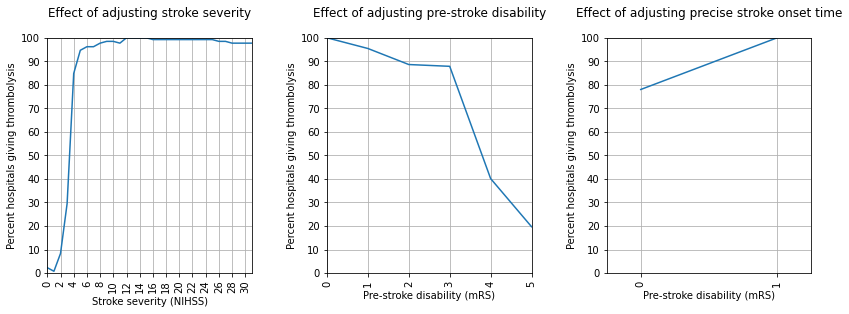

In [14]:
fig = plt.figure(figsize=(12,5))
number_hopsitals = len(hospitals)


ax1 = fig.add_subplot(1,3,1)
x1 = range(len(number_thrombolysing_NIHSS))
y1 = (np.array(number_thrombolysing_NIHSS) / number_hopsitals) * 100
ax1.plot(x1, y1)
ax1.set_xlabel('Stroke severity (NIHSS)')
ax1.set_ylabel('Percent hospitals giving thrombolysis')
ax1.set_xticks(np.arange(0,31,2))
ax1.set_xticklabels(ax1.get_xticks(), rotation = 90)
ax1.set_yticks(np.arange(0,101,10))
ax1.set_ylim(0,100)
ax1.set_xlim(0,31)
ax1.set_title('Effect of adjusting stroke severity\n')
ax1.grid()

ax2 = fig.add_subplot(1,3,2)
x2 = range(len(number_thrombolysing_mrs))
y2 = (np.array(number_thrombolysing_mrs) / number_hopsitals) * 100
ax2.plot(x2, y2)
ax2.set_xlabel('Pre-stroke disability (mRS)')
ax2.set_ylabel('Percent hospitals giving thrombolysis')
ax2.set_xticks(range(6))
ax2.set_xticklabels(ax2.get_xticks(), rotation = 90)
ax2.set_yticks(np.arange(0,101,10))
ax2.set_ylim(0,100)
ax2.set_xlim(0,5)
ax2.set_title('Effect of adjusting pre-stroke disability\n')
ax2.grid()

ax3 = fig.add_subplot(1,3,3)
x3 = range(len(number_thrombolysing_precise_onset))
y3 = (np.array(number_thrombolysing_precise_onset) / number_hopsitals) * 100
ax3.plot(x3, y3)
ax3.set_xlabel('Pre-stroke disability (mRS)')
ax3.set_ylabel('Percent hospitals giving thrombolysis')
ax3.set_xticks(range(2))
ax3.set_xticklabels(ax3.get_xticks(), rotation = 90)
ax3.set_yticks(np.arange(0,101,10))
ax3.set_ylim(0,100)
ax3.set_xlim(-0.25, 1.25)
ax3.set_title('Effect of adjusting precise stroke onset time\n')
ax3.grid()

plt.tight_layout(pad=3)
plt.savefig('./output/synthetic_patients.jpg', dpi=300)
plt.show()

## Examples of patient values

Base patient.

In [15]:
X_adjusted = X_synthetic.copy()
y_probs = model.predict_proba(X_adjusted)[:,1]
y_pred = y_probs > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Number of hospitals giving thrombolysis: 132
Percent of hospitals that would give thrombolsysis: 100.0


In [36]:
def return_indices_for_min_median_max_value_of_array(array):

    temp = array.argsort()
    ranks = temp.argsort()
    median_position = int(len(array)/2)
    
    hospital_index_list = []
    hospital_index_list.append(ranks.argmin())
    hospital_index_list.append(np.where(ranks==median_hospital)[0][0])
    hospital_index_list.append(ranks.argmax())
    
    return(hospital_index_list)

Show waterfall plots of the patient attending three hospitals: lowest, medium and highest likelihood to give thrombolysis.

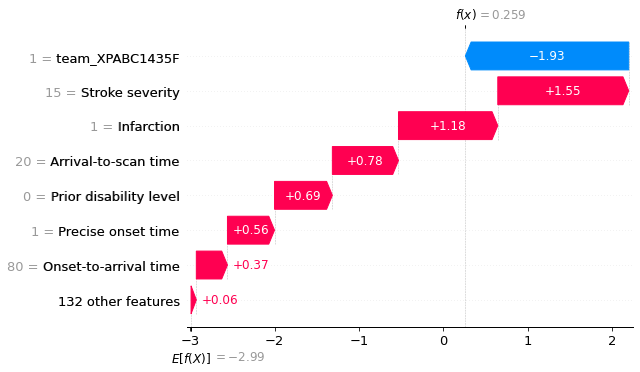

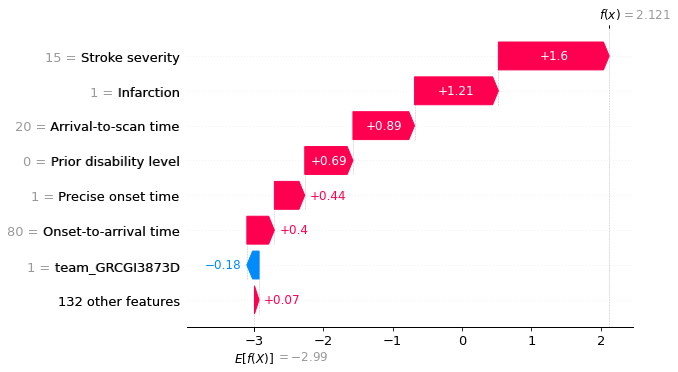

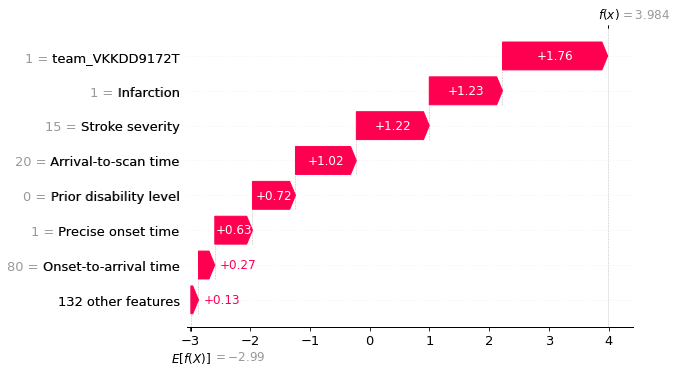

In [42]:
# Calculate the shap_values for the patient going to each hospital
shap_values_extended = explainer(X_adjusted)

# For just the hospital want to plot
for h in hospital_index_list:

    fig = waterfall.waterfall(shap_values_extended[h],
                               show=False, max_display=8)#, y_reverse=True)
    

    #plt.savefig(f'output/{notebook}_{model_text}_waterfall_logodds_low.jpg', 
#            dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.show()

Want to put these figures in a subplot. Go back to kerry_03 branch to edit the code. Look at what is in "logistic_regression_single_fit_shap_waterfall_subplots.ipynb"

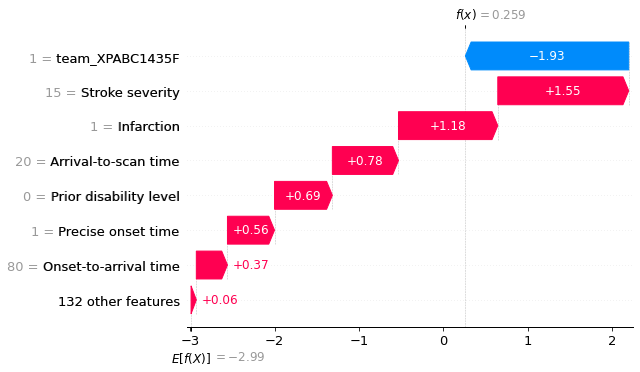

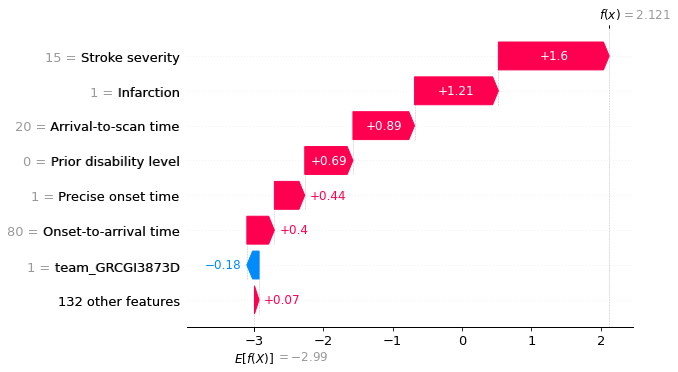

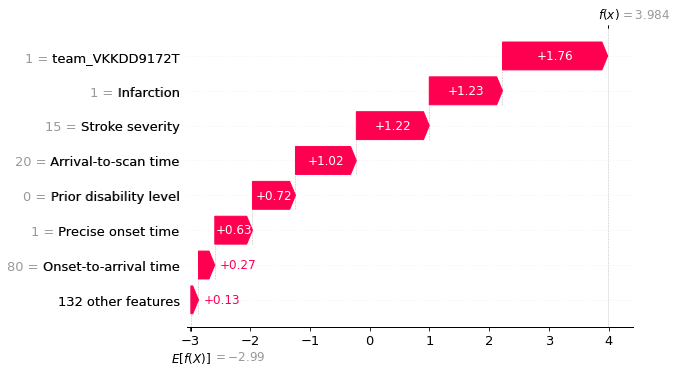

In [40]:
# Locate the three hospitals for lowest, mid and highest likelihood to give IVT
hospital_index_list = return_indices_for_min_median_max_value_of_array(y_probs)

# Calculate the shap_values for the patient going to each hospital
shap_values_extended = explainer(X_adjusted)

# Define the size of the overall figure
fig = plt.figure(figsize=(22, 11)) # 8 inch * 8 inch
subplot = 1

# For just the hospital want to plot
for h in hospital_index_list:
    
    # Create subplot 
    ax = fig.add_subplot(2,2,subplot) # Grid of 2x2, this is suplot 1
    instance = location_low_probability
    chosen_instance = X_test.iloc[instance]
    shap_values_instance = shapley_values_test[instance]
    expected_value = shapley_values_test_extended.base_values[0]
    chosen_predict = y_probs[instance]
    
    waterfall_plot(chosen_instance, 
                   shap_values_instance, 
                   expected_value,
                   chosen_predict,
                   ax=ax1, title="Low probability")

    fig = waterfall.waterfall(shap_values_extended[h],
                               show=False, max_display=8, ax=ax1)#, y_reverse=True)
    
    subplot += 1

    #plt.savefig(f'output/{notebook}_{model_text}_waterfall_logodds_low.jpg', 
#            dpi=300, bbox_inches='tight', pad_inches=0.2)
#    plt.show()

Stroke severity (NIHSS) = 4.

In [ ]:
X_adjusted = X_synthetic.copy()
X_adjusted['Stroke severity'] = 4
y_probs = model.predict_proba(X_adjusted)[:,1]
y_pred = y_probs > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Prior disability level (mRS) = 3.

In [ ]:
X_adjusted = X_synthetic.copy()
X_adjusted['Prior disability level'] = 3

y_probs = model.predict_proba(X_adjusted)[:,1]
y_pred = y_probs > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Estimated stroke onset time.

In [ ]:
X_adjusted = X_synthetic.copy()
X_adjusted['Precise onset time'] = 0

y_probs = model.predict_proba(X_adjusted)[:,1]
y_pred = y_probs > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Combined NIHSS = 5, pre-stroke mRS = 2, estimated stroke onset time.

In [ ]:
X_adjusted = X_synthetic.copy()
X_adjusted['Stroke severity'] = 5
X_adjusted['Prior disability level'] = 2
X_adjusted['Precise onset time'] = 0

y_probs = model.predict_proba(X_adjusted)[:,1]
y_pred = y_probs > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

For one of these hospitals that still gets thrombolysis, plot the waterfall plots for each patient scenario

In [ ]:
y_pred

## Show interactions with stroke severity

Show effect of varying NIHSS with:
* No other changes
* Pre-stroke disability (mRS) = 2
* Estimated stroke onset time
* Pre-stroke disability (mRS) = 2, and estimated stroke onset time

In [ ]:
# Base patient
control = []
for stroke_sev in range(41):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Stroke severity'] = stroke_sev
    y_probs = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_probs > 0.5
    control.append(y_pred.sum())

# Pre-stroke disability = 2
disability = []
for stroke_sev in range(41):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Prior disability level'] = 2
    X_adjusted['Stroke severity'] = stroke_sev
    y_probs = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_probs > 0.5
    disability.append(y_pred.sum())

# Estimated stroke onset
estimated = []
for stroke_sev in range(41):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Precise onset time'] = 0
    X_adjusted['Stroke severity'] = stroke_sev
    y_probs = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_probs > 0.5
    estimated.append(y_pred.sum())

# Estimated stroke onset + Pre-stroke disability = 2
disability_estimated = []
for stroke_sev in range(41):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Precise onset time'] = 0
    X_adjusted['Prior disability level'] = 2
    X_adjusted['Stroke severity'] = stroke_sev
    y_probs = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_probs > 0.5
    disability_estimated.append(y_pred.sum())

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

x = range(len(number_thrombolysing_NIHSS))

y1 = (np.array(control) / number_hopsitals) * 100
ax.plot(x, y1, label = 'Base patient')

y2 = (np.array(disability) / number_hopsitals) * 100
ax.plot(x, y2, label = 'Pre-stroke mRS = 2')

y3 = (np.array(estimated) / number_hopsitals) * 100
ax.plot(x, y3, label = 'Estimated onset time')

y4 = (np.array(disability_estimated) / number_hopsitals) * 100
ax.plot(x, y4, label = 'Estimated onset time + Pre-stroke mRS = 2')


ax.set_xlabel('Stroke severity (NIHSS)')
ax.set_ylabel('Percent hospitals giving thrombolysis')
ax.set_xticks(np.arange(0,31,2))
ax.set_yticks(np.arange(0,101,10))
ax.set_ylim(0,100)
ax.set_xlim(0,31)
ax.grid()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
    fancybox=True, shadow=False, ncol=2)

plt.savefig('./output/synthetic_patient_interactions.jpg', dpi=300)
plt.show()

## Observations

* There are interactions between features in the number of hopsitals that would give patients thrombolysis.

The number of hospitals giving thrombolysis:

* Base patient: 132 (99%)
* Base patient, but NIHSS = 5: 120 (91%)
* Base patient, but pre-stroke disability = 2: 126 (96%)
* Base patient, but estimated stroke onset time: 84 (64%)
* Base patient, but NIHSS = 5, pre-stroke disability = 2, estimated stroke onset time: 3 (2.3%)